In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn
from sklearn.model_selection import RandomizedSearchCV, ShuffleSplit
import seaborn as sns
import sys
import torch

import warnings
#warnings.filterwarnings('ignore')
#warnings.simplefilter('ignore')

In [4]:
from ZORO import benchmarkfunctions
from ZORO import optimizers

## Generate Data

In [5]:
# Dimensionality of data -- we tweak this to run our experiments
dim = 100             #10, 100, 1000, 10000
informative = 100     # 1,  10,  100,  1000

In [6]:
from sklearn.datasets import make_classification, make_blobs
# Cluster of points normally distributed (std=1) about vertices
# of an n_informative-dim hypercube with sides of length 2*class_sep

# Features are ordered: n_informative, n_redundant, n_repeated, 
# then random noise
def generate_samples(n_features, n_informative, n_samples=100):
    """
    return make_blobs(
        n_samples=n_samples,
        n_features=n_features,
        centers=2,
        random_state=42
        
    )
    """
    return make_classification(
        n_samples=n_samples, 
        n_features=n_features, 
        n_informative=n_informative,
        n_redundant=0, 
        n_repeated=0, 
        n_classes=2, 
        n_clusters_per_class=1, 
        flip_y=0.01, 
        class_sep=2, 
        random_state=42,
        shuffle=False
    )

X, y = generate_samples(dim, informative)

### Plot of Projection onto 2 Dimensions

In [7]:
from sklearn.decomposition import PCA

In [8]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

<AxesSubplot:>

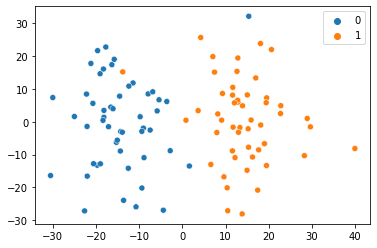

In [9]:
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=y)

## Linear Separator

In [10]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=42, max_iter=1000)
clf.fit(X, y)
print("Number of iterations", clf.n_iter_)
print("Accuracy:", clf.score(X, y))

Number of iterations 43
Accuracy: 1.0


In [11]:
w_norm = np.linalg.norm(clf.coef_)

## ZORO Attack

In [12]:
# Adversarial Attack Loss
class AttackLoss(object):
    '''An implementation of the sparse quadric function.'''
    def __init__(self, predictor, lamb, norm, x_original, y_true, y_attack):
        self.predictor = predictor
        self.lamb = lamb
        self.norm = norm
        
        self.x_original = x_original
        self.y_true = y_true
        self.y_attack = y_attack
        
    def __call__(self, x_attack):
        ## (f(x + delta) - y_attack + y_true)^2 + lambda ||delta||_0
        prediction = self.predictor.decision_function(x_attack)
                
        return (prediction - self.y_attack + self.y_true)**2 \
              + self.lamb * np.linalg.norm((x_attack - self.x_original), self.norm, axis=1)

In [19]:
class AdaZOROExperiment:
    
    def __init__(self, step_size=None, delta=None, max_cosamp_iter=None, 
                 cosamp_tol=None, prop_sparsity=None, lamb=None, norm=None,
                 function_budget=None, num_samples_constant=None, phi_cosamp=None,
                 phi_lstsq=None, compessible_constant=None):
        self.step_size = step_size
        self.delta = delta
        self.max_cosamp_iter = max_cosamp_iter
        self.cosamp_tol = cosamp_tol
        self.prop_sparsity = prop_sparsity
        self.lamb = lamb
        self.norm = norm
        self.function_budget = function_budget
        self.num_samples_constant=num_samples_constant
        self.phi_cosamp=phi_cosamp
        self.phi_lstsq=phi_lstsq
        self.compessible_constant=compessible_constant
        
    def score(self, X, y):
        return self.loss
    
    def get_params(self, deep=True):
        return {
            # Parameters for ZORO. 
            "step_size": self.step_size,
            "delta": self.delta,
            "max_cosamp_iter": self.max_cosamp_iter,
            "cosamp_tol": self.cosamp_tol,
            "prop_sparsity": self.prop_sparsity,
            "lamb" : self.lamb,
            "norm" : self.norm,
            "function_budget" : self.function_budget,
            "num_samples_constant": self.num_samples_constant,
            "phi_cosamp": self.phi_cosamp,
            "phi_lstsq": self.phi_lstsq,
            "compessible_constant": self.compessible_constant,
        }
    
    def set_params(self, **kwargs):
        for parameter, value in kwargs.items():
            setattr(self, parameter, value)
        return self
    
    def fit(self, X, y):
        self.report = []
        
        params = {
            "step_size": self.step_size,
            "delta": self.delta,
            "max_cosamp_iter": self.max_cosamp_iter,
            "cosamp_tol": self.cosamp_tol,
            "prop_sparsity": self.prop_sparsity,
            "lamb" : self.lamb,
            "norm" : self.norm,
            "function_budget" : self.function_budget,
            "num_samples_constant": self.num_samples_constant,
            "phi_cosamp": self.phi_cosamp,
            "phi_lstsq": self.phi_lstsq,
            "compessible_constant": self.compessible_constant,
        }
        
        print(params)

        params["sparsity"] = int(params["prop_sparsity"] * X.shape[1])
        params["num_samples"] = int(np.ceil(np.log(X.shape[1])*params["sparsity"]))

        # Compute attack loss for each data point individually
        for i in range(len(X)):
            x0           = X[i, :]
            xx0          = x0.copy()

            label        = y[i]
            label_attack = 1 - y[i]

            obj_func = AttackLoss(
                predictor=clf, 
                lamb=self.lamb, 
                norm=self.norm, 
                x_original=xx0,
                y_true=label,
                y_attack=label_attack
            )

            # initialize optimizer object
            self.report.append([{"evals": 0, "x": x0, "y": label, "sparsity": params["sparsity"], "loss": obj_func(np.expand_dims(x0, 0))[0]}])
            opt = optimizers.AdaZORO(x0, obj_func, params, function_budget=self.function_budget, function_target=0.001)

            # the optimization routine
            termination = False
            while termination is False:
                # optimization step
                # solution_ZORO = False until a termination criterion is met, in which 
                # case solution_ZORO = the solution found.
                # termination = False until a termination criterion is met.
                # If ZORO terminates because function evaluation budget is met, 
                # termination = B
                # If ZORO terminated because the target accuracy is met,
                # termination= T.

                evals_ZORO, solution_ZORO, sparsity, termination = opt.step()

                # save some useful values
                self.report[-1].append({"evals" : evals_ZORO, "x": solution_ZORO, "sparsity": sparsity, "loss": np.mean(opt.fd)})
                # print some useful values
                opt.report( f'Estimated f(x_{i}): %f  function evals: %d\n' %
                    (np.mean(opt.fd), evals_ZORO) )
        self.loss = sum([self.report[i][-1]["loss"] for i in range(len(self.report))]) / len(self.report)
    

class ZOROExperiment:       
    
    def __init__(self, step_size=None, delta=None, max_cosamp_iter=None, 
                 cosamp_tol=None, prop_sparsity=None, lamb=None, norm=None,
                 function_budget=None):
        self.step_size = step_size
        self.delta = delta
        self.max_cosamp_iter = max_cosamp_iter
        self.cosamp_tol = cosamp_tol
        self.prop_sparsity = prop_sparsity
        self.lamb = lamb
        self.norm = norm
        self.function_budget = function_budget
        
    def score(self, X, y):
        return self.loss
    
    def get_params(self, deep=True):
        return {
            # Parameters for ZORO. 
            "step_size": self.step_size,
            "delta": self.delta,
            "max_cosamp_iter": self.max_cosamp_iter,
            "cosamp_tol": self.cosamp_tol,
            "prop_sparsity": self.prop_sparsity,
            "lamb" : self.lamb,
            "norm" : self.norm,
            "function_budget" : self.function_budget
        }
    
    def set_params(self, **kwargs):
        for parameter, value in kwargs.items():
            setattr(self, parameter, value)
        return self
    
    def fit(self, X, y):
        self.report = []
        
        params = {
            "step_size": self.step_size,
            "delta": self.delta,
            "max_cosamp_iter": self.max_cosamp_iter,
            "cosamp_tol": self.cosamp_tol,
            "prop_sparsity": self.prop_sparsity,
            "lamb" : self.lamb,
            "norm" : self.norm,
            "function_budget" : self.function_budget
        }
        
        params["sparsity"] = int(params["prop_sparsity"] * X.shape[1])
        params["num_samples"] = int(np.ceil(np.log(X.shape[1])*params["sparsity"]))

        # Compute attack loss for each data point individually
        for i in range(len(X)):
            x0           = X[i, :]
            xx0          = x0.copy()

            label        = y[i]
            label_attack = 1 - y[i]

            obj_func = AttackLoss(
                predictor=clf, 
                lamb=self.lamb, 
                norm=self.norm, 
                x_original=xx0,
                y_true=label,
                y_attack=label_attack
            )

            # initialize optimizer object
            self.report.append([{"evals": 0, "x": x0, "y": label, "loss": obj_func(np.expand_dims(x0, 0))[0]}])
            opt = optimizers.ZORO(x0, obj_func, params, function_budget=self.function_budget, function_target=0.001)

            # the optimization routine
            termination = False
            while termination is False:
                # optimization step
                # solution_ZORO = False until a termination criterion is met, in which 
                # case solution_ZORO = the solution found.
                # termination = False until a termination criterion is met.
                # If ZORO terminates because function evaluation budget is met, 
                # termination = B
                # If ZORO terminated because the target accuracy is met,
                # termination= T.

                evals_ZORO, solution_ZORO, termination = opt.step()

                # save some useful values
                self.report[-1].append({"evals" : evals_ZORO, "x": solution_ZORO, "loss": np.mean(opt.fd)})
                # print some useful values
                opt.report( f'Estimated f(x_{i}): %f  function evals: %d\n' %
                    (np.mean(opt.fd), evals_ZORO) )
        self.loss = sum([self.report[i][-1]["loss"] for i in range(len(self.report))]) / len(self.report)

### Hyperparameter Search

In [24]:
# Parameters to search for ZORO attack
params = {
    "step_size": [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2],
    "delta": [1e-3, 1e-4, 1e-5], 
    "max_cosamp_iter": [5, 10, 15, 20, 25],
    "cosamp_tol": [0.5], 
    "prop_sparsity": [0.05, 0.10, 0.15, 0.20, 0.25], 
    "lamb" : [0.1], 
    "norm" : [2],
    "function_budget": [5e4] # for hyperparameter tuning, we give this as a budget
}

adaparams = {
    "step_size": [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2],
    "delta": [1e-3, 1e-4, 1e-5], 
    "max_cosamp_iter": [5, 10, 15, 20, 25],
    "cosamp_tol": [0.5], 
    "prop_sparsity": [0.05, 0.10, 0.15, 0.20, 0.25], 
    "lamb" : [0.1], 
    "norm" : [2],
    "function_budget": [5e4], # for hyperparameter tuning, we give this as a budget
    "num_samples_constant": [1], 
    "phi_cosamp": [0.2, 0.4, 0.6, 0.8],
    "phi_lstsq": [0.05, 0.1, 0.15, 0.20, 0.25],
    "compessible_constant": [1, 1.1, 1.25, 1.5, 2]
}

In [29]:
clf_search = sklearn.model_selection.RandomizedSearchCV(
    estimator = ZOROExperiment(),
    param_distributions = params,
    n_iter = 100, # Run 100 random trials
    n_jobs = 20, # Run 20 jobs at once
    refit = False,
    cv = ShuffleSplit(n_splits=1, train_size=16, random_state=42), # We attack the same 16 examples for every trial
    error_score=np.nan,
    random_state = 42
)

In [30]:
best_params = search_results.cv_results_["params"][0]
best_params.update({"function_budget" : 5e4})
best_exp = ZOROExperiment(**best_params)
best_exp.fit(X_sel[:16,:], y_sel[:16])

Estimated f(x_7): 5.711620  function evals: 29962
Estimated f(x_7): 2.070445  function evals: 39050
Estimated f(x_15): 18.063905  function evals: 1775
Estimated f(x_15): 7.729816  function evals: 41393
Estimated f(x_15): 7.729816  function evals: 41464
Estimated f(x_15): 7.729816  function evals: 41535
Estimated f(x_15): 7.729816  function evals: 41606
Estimated f(x_15): 7.729816  function evals: 41677
Estimated f(x_15): 7.729816  function evals: 41748
Estimated f(x_15): 7.729816  function evals: 41819
Estimated f(x_15): 7.729816  function evals: 41890
Estimated f(x_15): 7.729816  function evals: 41961
Estimated f(x_15): 7.729816  function evals: 42032
Estimated f(x_15): 7.729816  function evals: 42103
Estimated f(x_15): 7.729816  function evals: 42174
Estimated f(x_15): 7.729816  function evals: 42245
Estimated f(x_15): 7.729816  function evals: 42316
Estimated f(x_15): 7.729816  function evals: 42387
Estimated f(x_15): 7.729816  function evals: 42458
Estimated f(x_15): 7.729816  func

#### Save Reports

In [45]:
torch.save(best_exp.report, f"gaussian_d{dim}_20220616_report.pt")

### Reload Best Attacker Data and Plot Graphs

In [46]:
dim = 100
report = torch.load(f"gaussian_d{dim}_20220616_report.pt")

In [61]:
i = 0
original = report[i][0]["x"]

iteration = range(len(report[i]))
number_evals = [report[i][j]["evals"] for j in range(len(report[i]))]
perturbation_norms = np.stack([np.linalg.norm(original - report[i][j]["x"], 2) for j in range(len(report[i]))])
predictions = clf.decision_function(np.stack([report[i][j]["x"] for j in range(len(report[i]))]))

#### Fig 1

PCA of Data Points, Four Groupings:
1. Original Cluster 1
2. Original Cluster 2
3. Attack Points 1->2
4. Attack Points 2->1

In [1]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

NameError: name 'PCA' is not defined

In [2]:
sns.scatterplot(x=X_reduced[:,0], y=X_reduced[:,1], hue=y)

NameError: name 'sns' is not defined

#### Fig 2

PCA of Example Point:
1. Original Cluster 1
2. Original Cluster 2
3. Trace of Attack over Iterations

#### Fig 3

Distance from Hyperplane (Vector Norm)

(0.0, 5000.0)

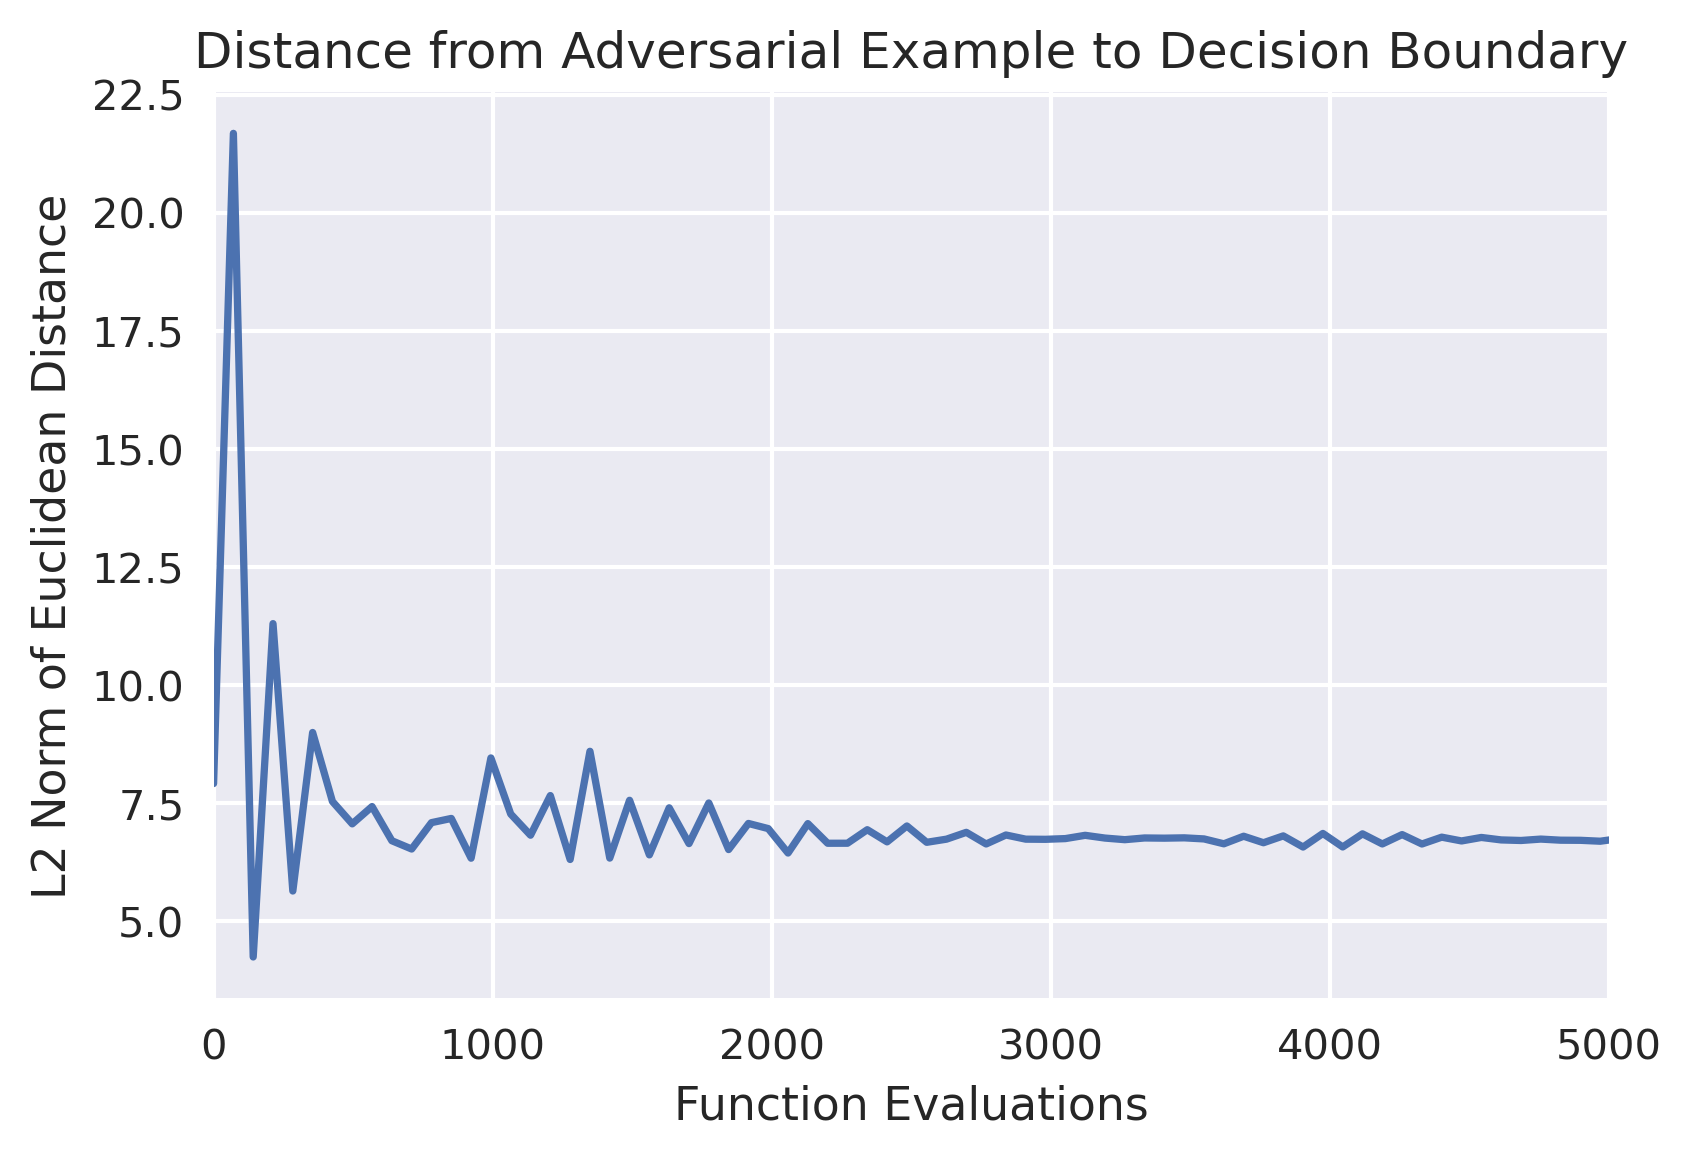

In [88]:
plt.figure(figsize=(6, 4), dpi=300)
sns.lineplot(x=number_evals, y=abs(predictions/w_norm))
plt.ylabel("L2 Norm of Euclidean Distance")
plt.xlabel("Function Evaluations")
plt.title("Distance from Adversarial Example to Decision Boundary")
plt.xlim(0, 5000)

#### Fig 4

Distance from Input to Attack Vector (Vector Norm)

(0.0, 5000.0)

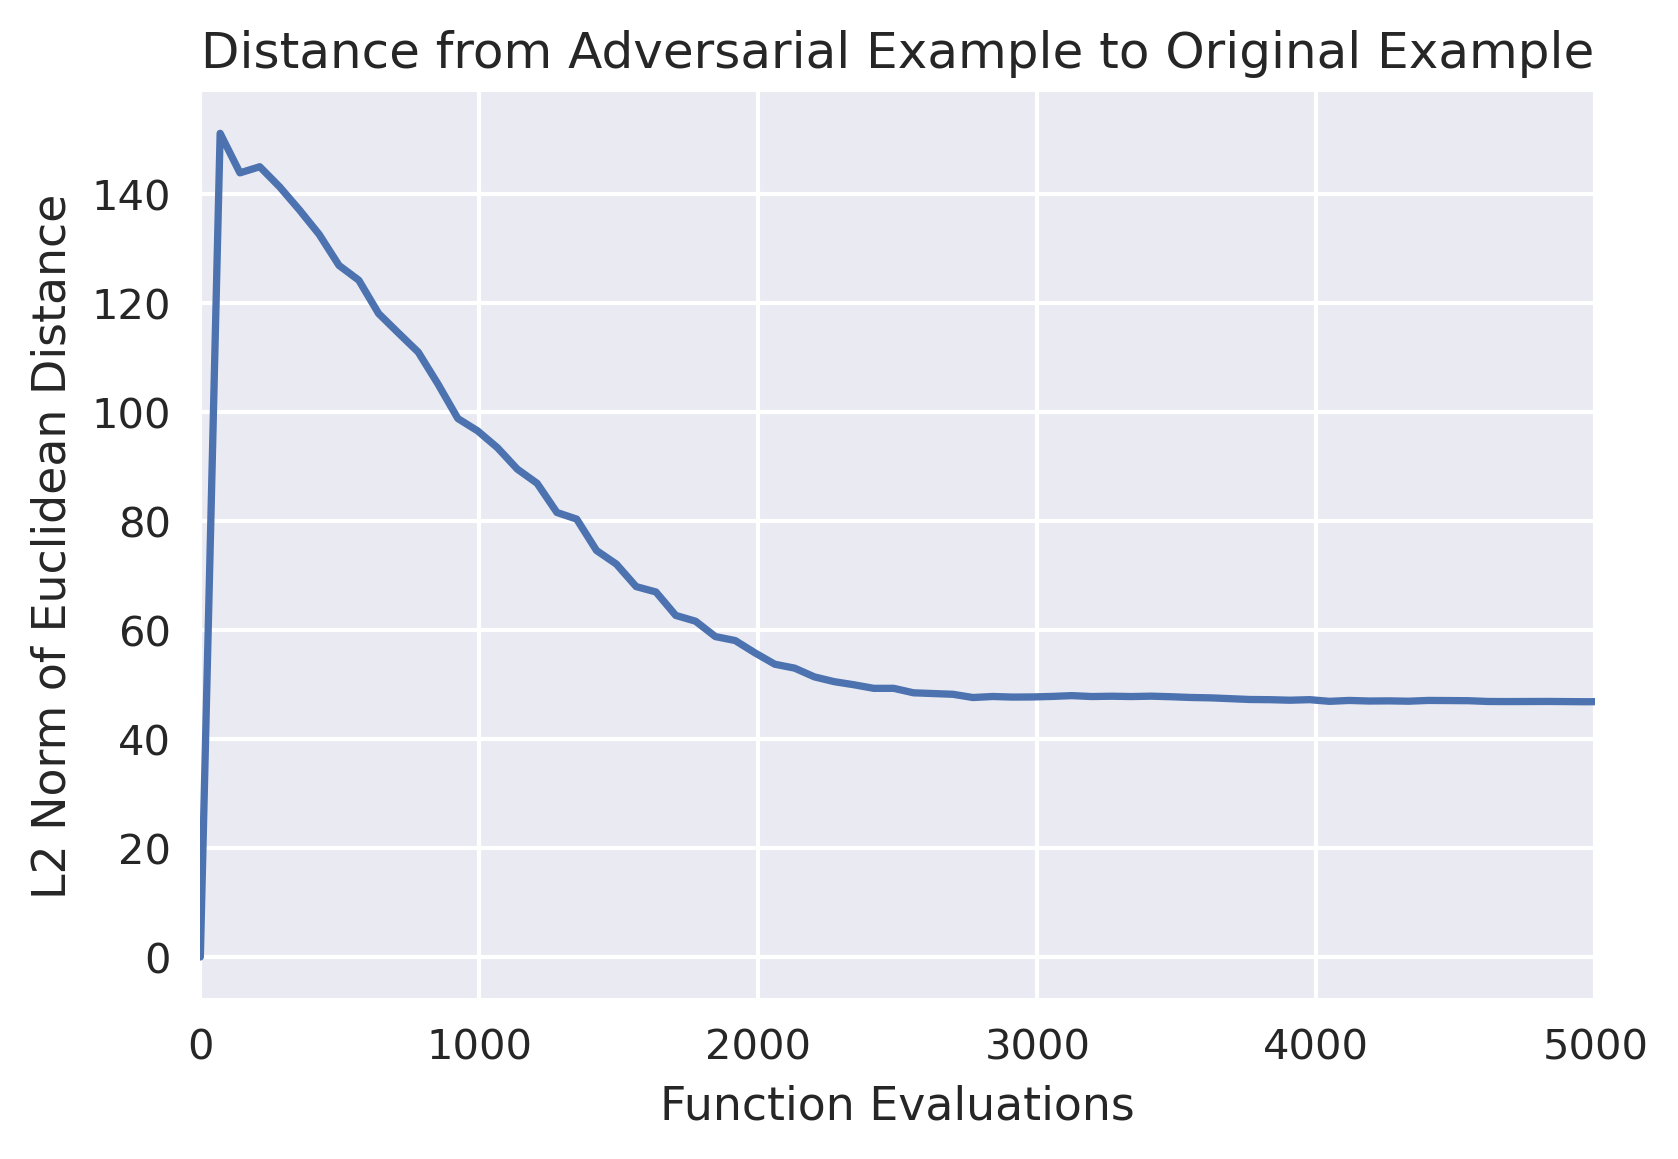

In [89]:
plt.figure(figsize=(6, 4), dpi=300)
sns.lineplot(x=number_evals, y=perturbation_norms)
plt.ylabel("L2 Norm of Euclidean Distance")
plt.xlabel("Function Evaluations")
plt.title("Distance from Adversarial Example to Original Example")
plt.xlim(0, 5000)

#### Fig 5

Movement in Hyperplane Direction Norm versus Total Movement Norm